# Challenge - SVM

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

In [42]:
#Imports
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Featrure Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

#Data Infrastructure
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.model_selection import cross_val_score

#Models
from sklearn.svm import SVC


In [2]:
#Bring in Data
raw_data = pd.read_csv('epi_r.csv')

#### EDA

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB


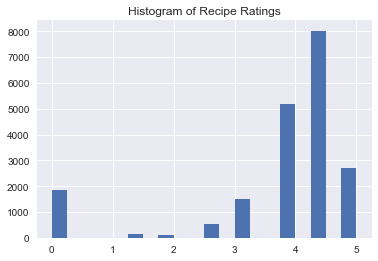

In [3]:
#Tring to predict rating.
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [6]:
#Breakdown of the rating
raw_data['rating'].value_counts()

4.375    8019
3.750    5169
5.000    2719
0.000    1836
3.125    1489
2.500     532
1.250     164
1.875     124
Name: rating, dtype: int64

In [5]:
#Check Nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [8]:
raw_data.dropna(inplace=True)

In [9]:
#Breakdown of the rating after dropping nulls
raw_data['rating'].value_counts()

4.375    6552
3.750    4136
5.000    2106
0.000    1296
3.125    1165
2.500     405
1.250     123
1.875      81
Name: rating, dtype: int64

In [7]:
#Lets turn this into a binary classifier "Great Rating" Where above 4 is great 
raw_data['Great Rating'] = np.where(raw_data['rating']>=4.0,1,0)

In [11]:
#Split the data
X = raw_data.drop(['rating', 'Great Rating','title'],1)
Y = raw_data['Great Rating']

### Feature Engineering

In [37]:
#Pretty Balanced
raw_data['Great Rating'].value_counts()

1    8658
0    7206
Name: Great Rating, dtype: int64

In [17]:
#Choose the top 30 features
selector = SelectKBest(f_classif, k=30)
selector.fit(X,Y)

idx_selected = selector.get_support(indices=True)
K_features = X[X.columns[idx_selected]]

/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 97 199 225 229 247 292 298 323 385 401 528 647] are constant.
  UserWarning)
/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [25]:
#Do the test/train split
X_train, X_test, y_train, y_test = train_test_split(K_features,Y, test_size=0.3)

### Build Model

In [33]:
#Fit Model. Since its a binary classifier, will use SVC
svc = SVC()

svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
cross_val_score(svc, X_test, y_test, cv=5)

array([ 0.58342078,  0.56558237,  0.57878151,  0.54574132,  0.52681388])

#### Grid Search

In [46]:
svc = SVC()

parameters = {'C':[1, 10, 100, 1000]}

#Build the grid
grid = GridSearchCV(svc, parameters, cv=10, verbose=0)
#Fit the grid
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1, 10, 100, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

In [47]:
#Best Parameters
grid.best_params_

{'C': 10}

In [48]:
#Best Score
grid.best_score_

0.5801512968299711

In [41]:
#Get Metrics
pred_y_sklearn = grid.predict(X_test)

#Print Confusion matrix. Notice didnt predict anyone would leave. 
print('\n Accuracy by admission status')
print(pd.crosstab(pred_y_sklearn, y_test))

#Print R Score
print('\n Percentage accuracy')
print(grid.score(X_test, y_test))


 Accuracy by admission status
Great Rating     0     1
row_0                   
0              488   352
1             1740  2180

 Percentage accuracy
0.560504201681


In [43]:
#Print Classification Report
print(classification_report(y_test, pred_y_sklearn))

             precision    recall  f1-score   support

          0       0.58      0.22      0.32      2228
          1       0.56      0.86      0.68      2532

avg / total       0.57      0.56      0.51      4760

